In [1]:
# 이 단원에서 사용하는 이전 단원 내용들 처리
import numpy as np

class SingleLayer :    
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b # 직선 방정식 계산
        return z
    
    def backprop(self, x, err):
        w_grad = x * err                # 가중치에 대한 그래디언트 계산
        b_grad = 1 * err                # 절편에 대한 그레디언트 계산
        return w_grad, b_grad
    
    def activation(self, z):
        z = np.clip(z, -100, None)     # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))
        return a
            
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]   # 정방향 계산
        return np.array(z) >0                  # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

'훈련 노하우'<br>
모델을 안정적으로 훈련하기 위해 필요한 기법을 알아보자.<br>

<h1>5.1 검증 세트를 나누고 전처리 과정을 배움</h1>

4장에서는 '훈련 세트'와 '테스트 세트'를 나누어 사용했음.<br>
훈련 세트는 fit() 메서드에 전달되어 모델을 훈련하는 데에 사용.<br>
테스트 세트는 score() 메서드에 전달해 모델의 성능 평가에 사용.<br>

여기서는 '테스트 세트'의 사용 방법에 대해 조금 더 깊이 알아봄.<br>
목표는 '어느 데이터 세트에만 치우친 모델을 만들지 않는 것'임

<h3>5.1.1 테스트 세트로 모델을 튜닝함</h3>

4장에서는 SGDClassifier 클래스를 이용해 로지스틱 회귀 문제에 경사 하강법을 적용함.<br>
이때 loss 매개변수의 값을 log로 지정하여 로지스틱 손실 함수를 손실 함수로 지정함.<br>

1. 로지스틱 회귀로 모델 훈련하고 평가하기

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size = 0.2, random_state=42)

SGDClassifier 클래스를 이용하여 로지스틱 회귀 모델을 훈련함.<br>
fit() 메서드에 x_train_all, y_train_all을 전달해 모델을 훈련함.<br>
score() 메서드에 x_test, y_test를 전달해 성능을 평가함

In [3]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

정확도는 약 83% 임.<br>
이 성능이 만족스럽지 않다면 다른 손실 함수를 사용해도 됨.<br>
그런데 loss와 같은 매개변수의 값은 가중치나 절편처럼 알아서 학습되는 것이 아님.<br>
이런 값을 특별히 하이퍼파라미터라고 부름.<br>
loss의 값을 바꾸면 성능이 정말 좋아지는지 확인해 볼 것임.

2. 서포트 벡터 머신으로 모델 훈련하고 평가하기

SGDClassifier 클래스의 loss 매개변수를 log에서 hinge로 바꾸면 선형 서포트 벡터 머신 문제를 푸는 모델이 만들어짐.<br>
여기서 SVM 이란 '훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업' 임

In [4]:
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

성능 평가가 93%로 상승함.<br>
로지스틱 회귀로 만든 모델의 성능보다 좋아짐.<br>
'모델 튜닝' 이란 loss 매개 변수에 다른 값을 적용하는 것과 같은 행위를 말함.

그러나, 이 모델은 실전에서 좋은 성능을 내지 못할 확률이 높음. 왜그럴까?

<h3>5.1.2 테스트 세트로 모델을 튜닝하면 실전에서 좋은 성능을 기대하기 힘듦</h3>

테스트 세트로 모델을 튜닝하면 '테스트 세트에 대해서만 좋은 성능을 보여주는 모델'이 만들어짐.<br>
이러한 현상을 '테스트 세트의 정보가 모델에 새어 나갔다'고 하며,<br>
모델의 일반화 성능(generalization performance)이 왜곡됨.

<h3>5.1.3 검증 세트를 준비함</h3>

그렇다면 어떻게 해야할까?<br>
모델을 튜닝할 때 테스트 세트를 사용하지 않으면 됨.<br>
하지만 모델 튜닝을 위해선 성능 점수가 필요함.<br>
이럴 땐 테스트 세트는 모델 튜닝을 모두 마치고 실전에 투입하기 전에 딱 한번만 사용하는 것이 좋음.<br>
즉, 모델 튜닝을 위한 세트는 따로 준비해야 함.<br>

모델을 튜닝하는 용도의 세트는 '검증 세트(validation set)'라고 하며 훈련 세트를 조금 떼어 만듦.<br>
60% (훈련세트), 20% (검증세트), 20%(테스트 세트)<br>

1. 데이터 세트 준비하기

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

2. 검증 세트 분할하기<br>

처음부터 6:2:2로 분할하는 것이 아닌,<br>
8:2로 분할한 뒤, 다시 8:2로 나누는 것임.

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

3. 검증 세트 사용해 모델 평가하기

In [7]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

<h3>5.1.4 데이터 전처리와 특성의 스케일을 알아봄</h3>

사이킷 런은 데이터가 잘 가공되어 있음.<br>
그러나 실전 데이터는 형태가 균일하지 않을 수 있음.<br>
이런 경우 데이터를 적절히 가공하는 '데이터 전처리'과정이 필요함.

1. 특성의 스케일은 알고리즘에 영향을 줌<br>

여기서는 가공되지 않은 데이터는 다루지 않음.<br>
그러나, 잘 가공된 데이터도 특성의 스케일이 다른 경우엔 전처리를 해야 함.<br>

특성의 스케일이란 어떤 특성이 가지고 있는 값의 범위.<br>

<li>[사과1] 당도 4, 무게 540</li>
<li>[사과2] 당도 8, 무게 700</li>
<li>[사과3] 당도 2, 무게 480</li>

사과의 당도 범위는 1\~10이고, 사과의 무게 범위는 500\~1000임.<br>
바로 이 경우를 '두 특성의 스케일 차이가 크다'라고 함.<br>

경사 하강법은 스케일에 민감한 알고리즘이므로, 특성의 스케일을 맞추는 전처리를 해야 함.

<h3>5.1.5 먼저 스케일을 조정하지 않고 모델을 훈련해 봄</h3>

1. 훈련 데이터 준비하고 스케일 비교하기

['mean perimeter' 'mean area']


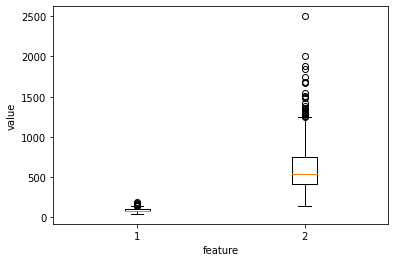

In [8]:
import matplotlib.pyplot as plt
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

mean perimeter 특성은 0\~200 사이인 반면, <br>
mean area 특성은 200\~2000 사이에 값이 집중됨.<br>
이 상태 그대로 경사 하강법 알고리즘을 적용시켜 봄.

2. 가중치를 기록할 변수와 학습률 파라미터 추가

In [9]:
class SingleLayer(SingleLayer) :
    def __init__(self, learning_rate = 0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []
        self.lr = learning_rate

learning_rate는 하이퍼파라미터이며 '학습률'을 의미하며, 이것으로 가중치의 업데이트 양을 조절함.<br>
일반적으로 손실 함수는 복잡한 굴곡을 가진 다차원 공간의 초평면(Hyperplane)임.<br>
만약 가중치를 큰 폭으로 업데이트하여 손실 함수가 최소가 될 수 있는 지점인 전역 최솟값을 지나면,<br>
최적의 해(최적의 가중치와 절편)을 구할 수 없게됨.<br>
따라서, 전역 최솟값을 놓치지 않도록 가중치의 업데이트 양을 조절할 수 있게 학습률을 조절함.

3. 가중치 기록하고 업데이트 양 조절하기

fit() 메서드에서 가중치가 바뀔 때마다 w_history 리스트에 가중치를 기록함.<br>

In [10]:
class SingleLayer(SingleLayer) :
    def fit(self, x, y, epoch=100):
        self.w = np.ones(x.shape[1])
        self.b = 0                      
        self.w_history.append(self.w.copy())                    # 가중치를 기록함
        np.random.seed(42)
        for i in range(epoch):         
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))  
            for i in indexes :             
                z = self.forpass(x[i])     
                a = self.activation(z)    
                err= -(y[i] - a)          
                w_grad, b_grad = self.backprop(x[i], err) 
                self.w -= w_grad * self.lr                      # 학습률을 적용한 가중치 업데이트
                self.b -= b_grad
                self.w_history.append(self.w.copy())             # 가중치 기록
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a)) 
            self.losses.append(loss/len(y))

4. 모델 훈련하고 평가하기

In [11]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

5. layer1 객체의 인스턴스 변수 w_history 확인<br>

w_history에는 100번의 에포크 동안 변경된 가중치가 모두 기록되어 있음.<br>
이때, 세 번째와 네 번재 요소 (w[2], w[3])는 각각 mean perimeter와 mean area 특성에 대한 가중치임.<br>
이 요소로 그래프를 그려봄.

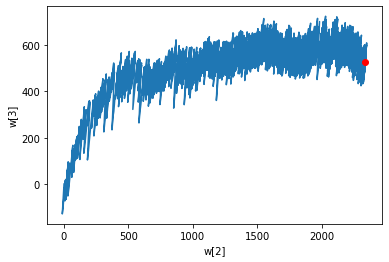

In [12]:
w2 = []
w3 = []
for w in layer1.w_history :
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

mean perimeter 보다 mean area이 스케일이 크므로 w3 값이 학습 과정에서 큰 폭으로 흔들리며 변화하고 있음.<br>
반면에 w2 값은 0부터 시작하여 조금씩 최적값에 가까워 짐.<br>
이 그래프의 현상을 'w3에 대한 그레디언트가 크기 때문에 w3 축을 따라 가중치가 크게 요동치고 있다'라고 함.<br>
즉, 갖중치의 최적값에 도달하는 동안 w3 값이 크게 요동치므로 모델이 불안정하게 수렴함.<br>
이 현상을 줄일 수 있는 방법이 스케일 조정임.

<h3>5.1.6 스케일을 조정해 모델을 훈련</h3>

[표준화 사용(standardization)]<br>

표준화는 특성값에서 평균을 빼고 표준 편차로 나누면 됨.<br>
표준화를 하면 평균이 0이고 분산이 1인 특성이 만들어 짐.<br>
z = (x - μ)/s <br>

사이킷런에 표준화를 위한 StandardScaler 클래스가 있지만 실제로 구현을 해 봄.

1. 넘파이로 표준화 구현하기<br>

넘파이의 mean(), std() 함수를 사용해 평균과 표준 편차를 계산하면 표준화를 쉽게 구현할 수 있음.<br>
axis 매개변수를 0으로 지정하면 2차원 배열의 열을 기준으로 통계치를 계산하여 하나의 행 벡터로 반환해줌.

In [13]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

2. 모델 훈련하기<br>

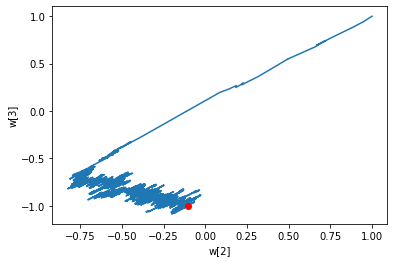

In [14]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

3. 모델 성능 평가하기

In [15]:
layer2.score(x_val, y_val)

0.37362637362637363

성능이 매우 좋지않음.<br>
그 이유는 검증 세트의 스케일을 바꾸지 않았기 때문임.<br>
따라서 이를 진행해봄.

In [16]:
train_val_mean = np.mean(x_val, axis=0)
train_val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - train_val_mean) / train_val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

<h3>5.1.7 스케일을 조정한 다음 실수하기 쉬운 함정</h3>

함정이란 '훈련 세트와 검증 세트가 다른 비율로 스케일이 조정된 경우'를 말함.<br>
이를 확인하기 위해 원본 훈련 세트와 검증 세트 \/ 전처리된 훈련 세트와 검증 세트에서 데이터를 50개씩 뽑아 산점도를 비교하며 함정에 대해 알아봄.

1. 원본 훈련 세트와 검증 세트로 산점도 그리기<br>

파란 점이 훈련 세트이고 빨간 점이 검증 세트임

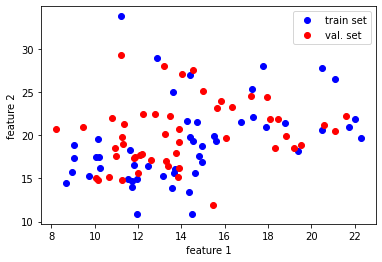

In [17]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

2. 전처리한 훈련 세트와 검증 세트로 산점도 그리기

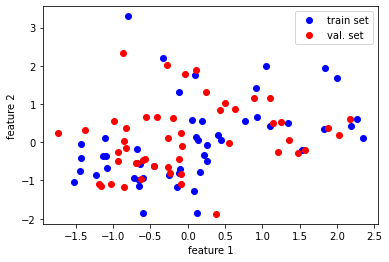

In [18]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

자세히 비교해 보면 미세하지만 훈련 세트와 검증 세트가 각각 다른 비율로 변환되었음을 알 수 있음.<br>
제대로 데이터를 전처리했다면 훈련 세트와 검증 세트의 거리가 그대로 유지되어야 함.<br>
점과 점 사이의 거리가 달라진 이유는 훈련 세트와 검증 세트를 각각 다른 비율로 전처리 했기 때문임.

3. 올바르게 검증 세트 전처리하기<br>

검증 세트를 훈련 세트와 같은 비율로 전처리해야 함.<br>
이를 위해 훈련 세트의 평균, 표준 편차를 사용해서 검증 세트를 변환함.

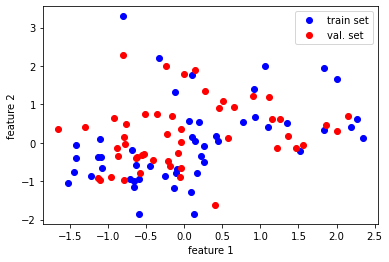

In [19]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

4. 모델 평가하기

In [20]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

<h1>5.2 과대적합과 과소적합</h1>

<h3>5.2.1 학습 곡선을 통해 과대적합과 과소적합을 알아봄.</h3>

과대적합이란 모델이 훈련 세트에서는 좋은 성능을 내지만 검증 세트에서는 낮은 성능을 내는 경우를 말함.<br>
예를 들어, 훈련 세트 정확도가 99%인 반면 검증 세트 정확도가 80%라면 과대적합을 의심할 수 있음.<br>

반면 과소적합은 훈련 세트와 검증 세트의 성능에는 차이가 크지 않지만 모두 낮은 성능을 내는 경우를 말함.

<li>[훈련 세트의 크기와 과대적합, 과소적합 분석하기]</li>


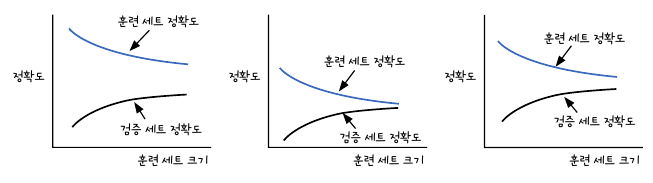

첫 번째 학습 곡선은 과대적합의 전형적인 모습임.<br>
훈련 세트와 검증 세트에서 측정한 성능의 간격이 큼.<br>
그래서 과대적합된 모델을 '분산이 크다(high variance)'라고도 함.<br>
과대적합의 주요 원인 중 하나는 훈련 세트에 충분히 다양한 패턴의 샘플이 포함되지 않은 경우임.<br>
훈련 세트에 다양한 패턴의 샘플이 없으니 검증 세트에 제대로 적응하지 못한 것임.<br>
이런 경우엔 더 많은 훈련 샘플을 모아 검증 세트의 성능을 향상시킬 수 있음.<br>
현실적인 한계로 훈련 샘플을 더 많이 모을 수 없는 경우엔 모델이 훈련 세트에 집착하지 않도록 가중치를 제한할 수도 있음.<br>
이를 '모델의 복잡도를 낮춘다'라고 함.<br>

두 번째 학습 곡선은 전형적인 과소적합의 모습임.<br>
훈련 세트와 검증 세트에서 측정한 성능의 간격은 점점 가까워 지지만 성능 자체가 낮음.<br>
그래서 과소적합된 모델을 '편향이 크다(high bias)'라고도 함.<br>
과소적합은 모델이 충분히 복잡하지 않아 훈련 데이터에 있는 패턴을 모두 잡아내지 못하는 현상임.<br>
과소적합을 해결하는 대표적인 방법은 복잡도가 더 높은 모델을 사용하거나 가중치의 규제를 완화하는 것임.<br>

마지막으로 세 번째 학습 곡선은 과대적합과 과소적합 사이에서 절충점을 찾은 모습임.

<li>[에포크와 손실 함수의 그래프로 과대적합과 과소적합 분석하기]</li>

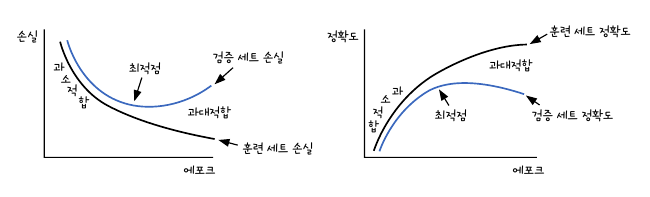

왼쪽 그래프는 검증 세트의 손실과 훈련 세트의 손실을 나타낸 것임.<br>
훈련 세트의 손실은 에포크가 진행될수록 감소하지만 검증 세트의 손실은 에포크의 횟수가 최적점을 지나면 오히려 상승함.<br>
최적점 이후에도 계속해서 훈련 세트로 모델을 학습시키면 모델이 훈련 세트의 샘플에 더 밀착하여 학습하기 때문임.<br>
즉 모델이 과대적합되기 시작함.<br>
반대로 최적점 이전에는 훈련 세트와 검증 세트의 손실이 비슷한 간격을 유지하면서 함께 줄어드는데, 이 영역에서 학습을 중지하면 과소적합된 모델이 만들어짐.<br>

오른쪽 그래프는 세로 축에 손실 대신 정확도를 사용한 것으로 해석은 동일함.

<li>[모델 복잡도와 손실 함수의 그래프로 과대적합과 과소적합 분석하기]</li>

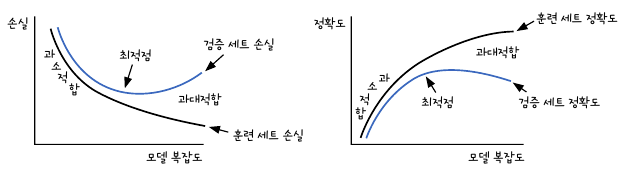

에포크 대신 모델 복잡도를 넣어 그래프를 표현하기도 함.<br>

모델 복잡도란 모델이 가진 학습 가능한 가중치 개수를 말하는데, 층의 개수나 유닛의 개수가 많아지면 복잡도가 높은 모델이 만들어짐.<br>
모델이 복잡해지면 무조건 좋을 것 같지만 실제로는 그렇지 않음.<br>
예를 들어 모델이 훈련 세트에만 잘 맞는 형태로 만들어지면 훈련세트에서만 좋은 성능을 내기 때문임.<br>
과대적합이 바로 그런 경우임.<br>

이제 부터는 적절한 에포크 횟수를 찾아볼 것임.

<h3>5.2.2 적절한 편향-분산 트레이드오프를 선택함</h3>

과소적합된 모델(편향)과 과대적합된 모델(분산) 사이의 관계를 편향-분산 트레이드 오프(bias-variance tradeoff)라고 함.<br>
우리는 편향이나 분산이 너무 커지지 않도록 적절한 중간 지점을 선택할 것임.

1. 검증 손실을 기록하기 위한 변수 추가하기<br>

훈련 세트의 손실을 기록했듯이 검증 세트에 대한 손실을 기록한 다음 기록한 값으로 그래프를 그려봄.<br>
이를 위해 SingleLayer 클래스의 __init__() 메서드에 self.val_lossess 인스턴스 변수를 추가함.

In [21]:
class SingleLayer(SingleLayer):
    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate

2. fit() 메서드에 검증 세트를 전달받을 수 있도록 x_val, y_val 매개변수를 추가함<br>
3. 검증 손실 계산하기

In [22]:
class SingleLayer(SingleLayer):
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= self.lr * w_grad
                self.b -= b_grad
                
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))
            self.update_val_loss(x_val, y_val)
            
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val))

4. 모델 훈련하기

In [23]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val = y_val)

5. 손실값으로 그래프 그려 에포크 횟수 지정하기

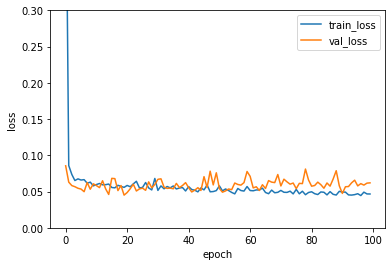

In [24]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

그래프를 보면 검증 손실이 대략 20번째 에포크 이후에 훈련 세트보다 높아지는 것을 알 수 있음.<br>
조금 더 자세히 말하면 에포크가 진행됨에 따라 가중치는 훈련 세트에 잘 맞게 되지만,<br>
검증 세트에는 잘 맞지 않게 되는 것임.<br>
따라서 이 모델은 20번의 에포크 이후에는 훈련할 필요가 없을 것임.

6. 훈련 조기 종료하기<br>

조기 종료(early stopping)을 진행함.

In [25]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.978021978021978

<h1>5.3 규제 방법을 배우고 단일층 신경망에 적용하기</h3>

5.2 에서 과대적합을 해결하는 대표적인 방법 중 하나로 가중치 규제(regularization)을 소개함.<br>
가중치 규제란 말 그대로 가중치의 값이 커지지 않도록 제한하는 기법임.<br>

간단한 샘플 데이터와 모델 2개를 그래프로 보며 가중치 규제를 알아봄.

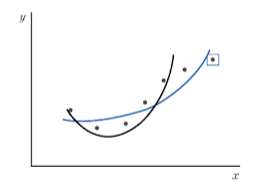

두 그래프 모두 점을 어느 정도 잘 표현함.<br>
둘 중 어떤 그래프가 성능이 더 좋은가?<br>
이 경우엔 경사가 급한 그래프 보다는 경사가 완만한 그래프가 성능이 좋다고 평가함.<br>
경사가 높은 그래프보다 경사가 낮은 그래프가 박스로 표시한 샘플 데이터를 더 잘 표현하기 때문임.<br>

그렇다면 샘플 데이터에 딱 맞는 그래프(아래)는 더 좋은 성능을 가질까?<br>
다음 그래프는 샘플 데이터를 정확히 관통하는 모델을 표현한 것임.<br>
이 경우엔 샘플 데이터 6개에 너무 집착한 나머지 박스로 표시한 샘플 데이터를 제대로 표현하지 못함.

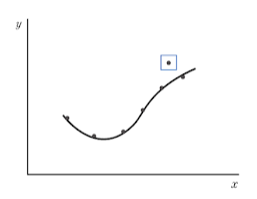

모델이 몇 개의 데이터에 집착하면 새로운 데이터에 적응하지 못하므로 좋은 성능을 가졌다고 할 수 없음.<br>
바로 이것을 '모델이 일반화되지 않았다'라고 말함.<br>
이럴 때 규제를 사용하여 가중치를 제한하면 모델이 몇 개의 데이터에 집착하지 않게 되므로 일반화 성능을 높일 수 있음.<br>

여기서는 대표적인 규제 기법인 L1 규제와 L2 규제를 알아보고, SingleLayer 클래스에 적용해 봄.

<h3>5.3.1 L1 규제를 알아봄</h3>

L1 규제는 손실 함수에 가중치의 절댓값인 L1 norm 을 추가함. (L1 norm은 다음과 같음)

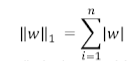

소문자 알파벳(w)는 벡터를 의미하며 이 식엔 없지만 대문자 볼드 알파벳은 행렬을 의미함.<br>
L1 norm의 n은 가중치의 개수를 의미하므로 L1 규제를 '가중치의 절댓값을 손실 함수에 더한 것'으로 이해해도 괜찮음.<br>

다음은 로지스틱 손실 함수이며, 이 함수에 L1 규제를 적용해 봄.<br>

L = -(ylog(a) + (1-y)log(1-a))<br>

앞에서 말했듯 손실 함수에 L1 norm을 더하면 L1 규제가 만들어짐.<br>
이때 L1 norm을 그냥 더하지 않고 규제의 양을 조절하는 파라미터 a를 곱한 후 더함.<br>

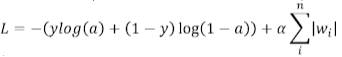

α는 L1 규제의 양을 조절하는 하이퍼파라미터임.<br>
예를 들어 α의 값이 크면 전체 손실 함수의 값이 커지지 않도록 w값의 합이 작아져야 함.<br>
이것을 보고 규제가 강해졌다고 함.(가중치가 작아졌으므로)<br>

반대로 α의 값이 작으면 w의 합이 커져도 손실 함수의 값이 큰 폭으로 커지지 않음.<br>
즉, 규제가 약해짐.<br>
경사 하강법으로 가중치를 업데이트하기 위하여 L1 규제를 적용한 로지스틱 손실 함수를 미분해 봄.

<h3>5.3.2 L1 규제의 미분</h3>

로지스틱 함수는 이미 미분해 보았으니, L1 규제만 미분해 봄.<br>
절댓값 |w|를 w에 대해 미분하면 w값의 부호만 남기 때문에 w 값을 미분한 결과인 w의 부호라는 의미로 sign(w)로 표현함.<br>
L1 규제를 적용한 손실 함수의 도함수는 다음과 같음.

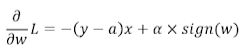

여기에서는 가중치 벡터 w에 대한 미분으로 확장하여 식을 전개함.<br>
이 식을 가중치 업데이트 식에 적용하면 다음과 같음.<br>
학습률을 적용하여 곱해줌.

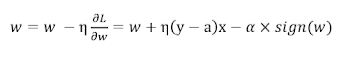

L1 규제를 추가한 로지스틱 손실 함수를 경사 하강법으로 최적화하는 것도 어렵지 않음.<br>
규제 하이퍼파라미터 α와 가중치의 부호를 곱해서 업데이트할 그래디언트에 더해주면 됨.

In [26]:
# w_grad += alpha * np.sign(w)

alpha 변수가 규제 하이퍼파라미터임.<br>
여기서 한 가지 볼 것은 절편에 대해서는 규제를 하지 않는다는 점임.<br>
절편은 모델에 영향을 미치는 방식이 가중치와 다르기 때문임.<br>
절편을 규제하면 모델을 어떤 방향으로 이동시킬 뿐 복잡도에는 영향을 주지 않음.<br>

SGDClassifier 클래스에서는 penalty 매개변수 값을 l1으로 지정하는 방법으로 L1 규제를 적용할 수 있음.<br>
또한 규제의 강도를 제어하는 하이퍼파라미터 α를 위한 alpha 매개변수를 제공함.

<li>[회귀 모델에 L1 규제를 추가한 것을 라쏘 모델이라고 함]</li>

회귀 모델에도 같은 원리를 적용하여 손실 함수(제곱 오차)에 L1 규제를 적용할 수 있음.<br>
이런 모델을 라쏘(Lasso) 라고 부름.<br>
라쏘는 가중치를 줄이다 못해 일부 가중치를 0으로 만들 수도 있음.<br>
가중치가 0인 특성은 모델에서 사용할 수 없다는 것과 같은 의미이므로 특성을 선택하는 효과를 얻을 수 있음.<br>

사이킷런에서는 skelarn.linear_model.Lasso 클래스에서 라쏘 모델을 제공함.<br>
L1 규제는 규제 하이퍼파라미터 α에 많이 의존함.<br>
즉, 가중치의 크기에 따라 규제의 양이 변하지 않으므로 규제 효과가 좋다고 할 수 없음.<br>

이번에는 규제 효과가 좋아 널리 사용하는 L2 규제를 알아봄.

<h3>5.3.3 L2 규제를 알아봄</h3>

L2 규제는 손실 함수에 가중치에 대한 L2 norm의 제곱을 더함.<br>
L2 norm은 다음과 같음.

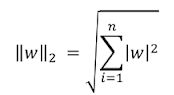

손실 함수에 L2 norm의 제곱을 더하면 L2 규제가 됨.<br>
이때 α는 L1 규제와 마찬가지로 규제의 양을 조절하기 위한 하이퍼파라미터이고, 1/2은 미분 결과를 보기 좋게 하기위해 추가함.

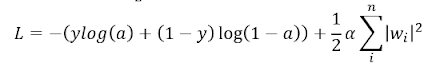

<h3>5.3.4 L2 규제의 미분</h3>

로지스틱 손실 함수의 미분은 이전과 동일함.<br>
L2 규제를 미분하면 간단히 가중치 벡터 w만 남음.

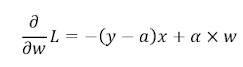

이 결과를 가중치 업데이트 식에 대입해 봄.<br>
η은 L1 규제에서 설명했던 학습률 하이퍼파라미터임.

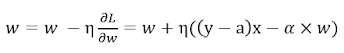

L2 규제를 경사 하강법 알고리즘에 적용하는 방법은 다음과 같음.<br>
그라디언트에 α와 가중치의 곱을 더해주면 됨.

In [27]:
# w_grad += alpha * w

L2 규제는 그래디언트 계산에 가중치의 갑 자체가 포함되므로 가중치의 부호만 사용하는 L1 규제보다 효과적임.<br>
또한, L2 규제는 가중치를 완전히 0으로 만들지 않음.<br>
가중치를 완전히 0으로 만들면 특성을 제외하는 효과는 있지만 모델의 복잡도가 떨어지기 때문임.

<li>[회귀 모델에 L2 규제를 적용한 것을 릿지 모델이라고 함]</li>

회귀 모델에 L2 규제를 적용한 것을 릿지(Ridge) 모델이라고 함.<br>
사이킷런에서는 릿지 모델을 sklearn.linear_model.Ridge 클래스로 제공함.<br>
SGDClassifier 클래스에서는 penalty 매개변수를 l2로 지정하여 L2 규제를 추가할 수 있음.<br>
두 클래스 모두 규제의 강도는 alpha 매개변수로 제어함.

<h3>5.3.5 L1 규제와 L2 규제 정리</h3>

경사 하강법에 규제를 추가하는 방법을 정리해보면 다음과 같음.<br>

1. L1 규제<br>

<li>w_grad += alpha * np.sign(w)</li>

2. L2 규제<br>

<li>w_grad += alpha * w</li>

<h3>5.3.6 로지스틱 회귀에 규제 적용</h3>

1. 그레디언트 업데이트 수식에 페널티 항 반영하기

In [28]:
class SingleLayer(SingleLayer) :
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

l1과 l2의 기본값은 0이고 이때는 규제를 적용하지 않음.

2. fit() 메서드에서 역방향 계산을 수행할 때 그레디언트에 페널티 항의 미분값을 더함.<br>

이때 L1 규제와 L2 규제를 따로 적용하지 않고 하나의 식으로 작성함.<br>
즉, L1 규제와 L2 규제를 동시에 수행할 수 있음.

In [29]:
class SingleLayer(SingleLayer):
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w         # 그라디언트에서 페널티 항의 미분값 더함
                self.w -= self.lr * w_grad
                self.b -= b_grad
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y) + self.reg_loss())
            self.update_val_loss(x_val, y_val)

3. 로지스틱 손실 함수 계산에 페널티 항 추가하기<br>

로지스틱 손실 함수를 계산할 때 페널티 항에 대한 값을 더해야 함.<br>
이를 위해 reg_loss() 메서드를 SingleLayer 클래스에 추가함.<br>
이 함수는 훈련 세트의 로지스틱 손실 함수의 값과 검증 세트의 로지스틱 손실 함수의 값을 계산할 때 모두 호출됨.

In [30]:
class SingleLayer(SingleLayer):
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

4. 검증 세트의 손실을 계산하는 update_val_loss() 메서드에서 reg_loss()를 호출하도록 수정함.

In [31]:
class SingleLayer(SingleLayer):
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

5. cancer 데이터 세트에 L1 규제 적용하기

L1 규제 강도에 따라 모델의 학습 곡선과 가중치가 어떻게 바뀌는지 확인함.<br>
규제 강도는 0.0001, 0.001, 0.01 세가지로 진행함.

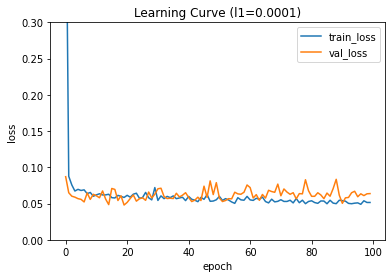

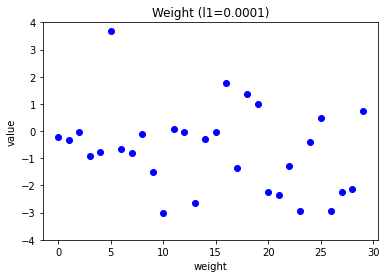

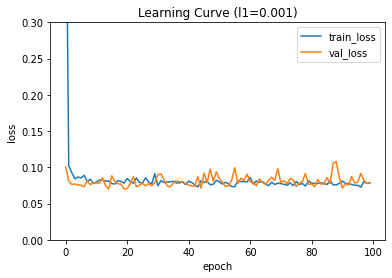

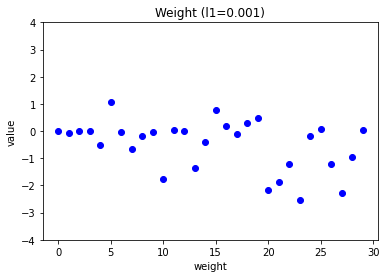

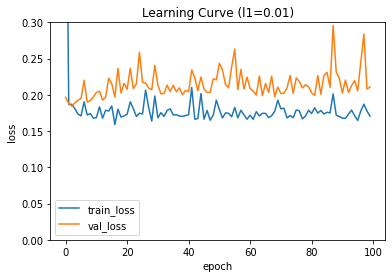

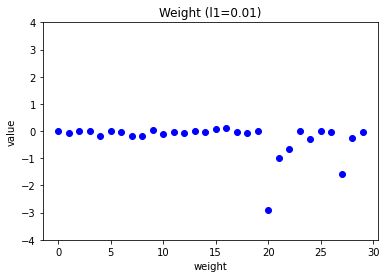

In [32]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

그래프를 보기 좋게 하기 위해 맷플롯립의 title() 함수로 제목을 넣고, ylim() 함수로 y축의 범위를 제한함.<br>
Learning Curve는 학습 곡선 그래프이고, Weight은 가중치에 대한 그래프임.<br>

학습 곡선 그래프를 보면 규제가 더 커질수록 훈련 세트의 손실과 검증 세트의 손실이 모두 높아짐.<br>
즉, 과소적합 현상이 나타남.<br>

가중치 그래플르 보면 규제 강도 l1 값이 커질수록 가중치의 값이 0에 가까워지게 됨.<br>
그래프를 보면 적절한 l1 하이퍼파라미터 값은 0.001 정도임.<br>

이 값을 사용하여 모델의 성능을 확인해 봄.

In [33]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

결과는 규제를 적용하지 않고 검증 세트로 성능을 평가했을 때의 값과 동일함.<br>
이 데이터 세트는 작기 때문에 규제 효과가 크게 나타나지 않음.<br>

이번엔 L2 규제를 적용해 봄.

6. cancer 데이터 세트에 L2 규제 적용하기

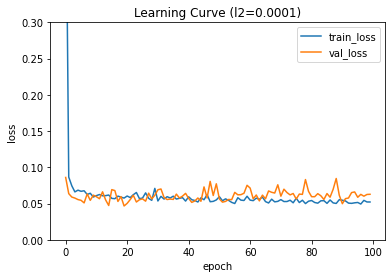

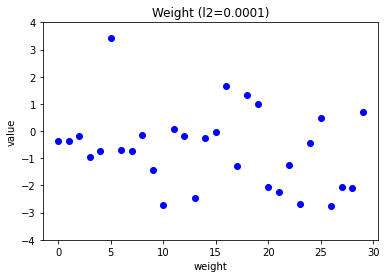

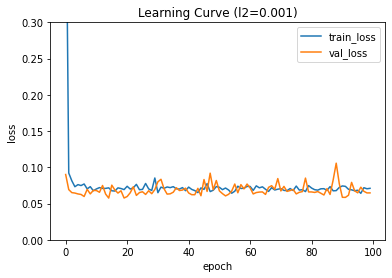

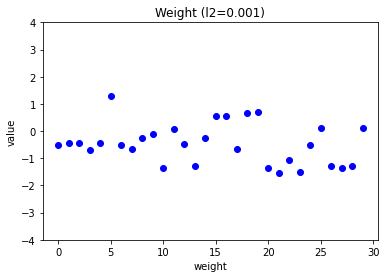

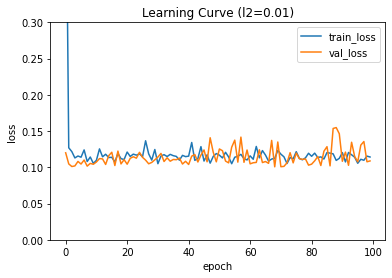

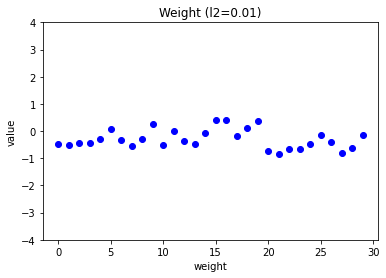

In [34]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

그래프를 보면 L2 규제도 L1 규제와 비슷한 양상을 보임.<br>
그러나 마지막 학습 곡선 그래프를 보면 L2 규제는 규제 강도가 강해져도(l2=0.01) L1 규제만큼 과소적합이 심해지지는 않음.<br>
가중치 그래프를 보아도 가중치가 0에 너무 가깝게 줄지 않는다는 것을 알 수 있음.<br>

L2 규제를 적용한 모델 역시 50번의 에포크 횟수만큼 훈련하고 성능을 평가해 봄.

In [35]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

L1 규제와 동일함.<br>
사실 cancer 데이터 세트의 샘플 개수가 아주 적어서 L1 규제를 적용한 모델이나 L2 규제를 적용한 모델의 성능 차이가 적음.<br>

여기서는 두 모델 모두 91개 검증 샘플 중 89개의 샘플을 올바르게 예측함.

In [36]:
np.sum(layer6.predict(x_val_scaled) == y_val)

89

L1 규제를 사용했을 때 보다 L2 규제를 사용했을 때 에포크가 크게 늘어남.<br>
L1 규제를 적용할 때는 20번의 에포크 동안 훈련을 했지만,<br>
L2 규제를 적용할 때는 50번의 에포크 동안 훈련을 함.<br>
이는 가중치를 강하게 제한했기 때문에 검증 세트의 손실값을 일정한 수준으로 유지하면서 알고리즘이 전역 최솟값을 찾는 과정을 오래 반복할 수 있었던 것임.

7. SGDClassifier에서 규제 사용하기<br>

사이킷런의 SGDClassifier 클래스도 L1 규제, L2 규제를 지원함.<br>
penalty 매개변수에 l1이나 l2를 매개변수 값으로 전달하고 alpha 매개변수에 규제의 강도를 지정하면 됨.

In [37]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

사이킷런에서는 SGDClassifier 클래스 이외에도,<br>
LogisticRegression, SVC, LinearSVC 클래스 등에서 L1 규제와 L2 규제를 지원하는데, <br>
이 클래스들은 페널티 항 대신 주손실 함수의 크기를 조절하기 위해 하이퍼파라미터 C를 곱해 줌.<br>
(C는 alpha와 반대의 역할을 함)

<h1>5.4 교차 검증을 알아보고 사이킷런으로 수행해봄</h1>

교차 검증은 전체 데이터 세트의 샘플 개수가 적을 때 유용하게 쓸 수 있는 방법임.<br>
특히 전체 데이터 세트의 샘플 개수가 많지 않을 때 검증 세트를 훈련 세트에서 분리하느라, 훈련 세트의 샘플 개수가 줄어들어 모델을 훈련시킬 데이터가 부족해지는 경우에 유용함.

<h3>5.4.1 교차 검증의 원리</h3>

교차 검증은 훈련 세트를 작은 덩어리로 나누어 다음과 같이 진행하며, 이때 훈련 세트를 나눈 작은 덩어리를 '폴드'라고 함.

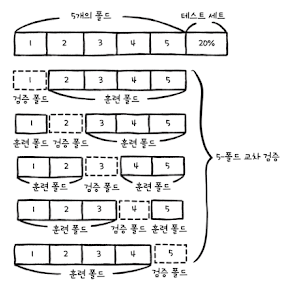

위 그림에서, 교차 검증은 전체 데이터 세트를 8:2로 나눈 다음 8에 해당하는 훈련 세트를 다시 5개의 작은 덩어리로 나눔.<br>
그런 다음 작은 덩어리를 1번씩 검증에 사용하고 나머지 덩어리를 훈련에 사용함.<br>

교차 검증 과정은 다음과 같음.<br>
<li>훈련 세트를 k개의 폴드(fold)로 나눔</li>
<li>첫 번째 폴드를 검증 세트로 사용하고 나머지 폴드(k-1개)를 훈련 세트로 사용함</li>
<li>모델을 훈련한 다음에 검증 세트로 평가함</li>
<li>차례대로 다음 폴드를 검증 세트로 사용하여 반복함</li>
<li>k개의 검증 세트로 k번 성능을 평가한 후 계산된 성능의 평균을 내어 최종 성능을 계산함</li>

이때 교차 검증은 훈련 세트를 k개의 폴드로 나누는 특징이 있으므로 k-폴드 교차 검증이라고 부름.<br>
k-폴드 교차 검증은 모든 훈련 세트가 평가에 1번씩 사용되므로 검증 점수가 안정적임.<br>
그리고 기존의 훈련 방법보다 더 많은 데이터로 훈련 가능함.<br>
예를 들어 k가 10이면 10개의 폴드가 생기므로 90% 샘플을 훈련에 사용하게 됨.<br>
기존의 6:2:2로 훈련, 검증, 테스트 세트를 나누는 방법과 비교하면 약 30% 정도 더 많은 데이터로 훈련할 수 있는 것임.

<h3>5.4.2 k-폴드 교차 검증 구현</h3>

1. 훈련 세트 사용하기<br>

기존의 방식은 전체 데이터 세트를 8:2의 비율로 나누어 훈련 세트와 테스트 세트를 얻음.<br>
그런 다음 다시 훈련 세트를 8:2의 비율로 나누어 훈련 세트와 검증 세트를 얻음.<br>
즉, 훈련, 검증, 테스트 세트를 완전히 나눔.<br>

하지만, k-폴드 교차 검증은 검증 세트가 훈련 세트에 포함됨.<br>
따라서 전체 데이터 세트를 다시 훈련 세트와 테스트 세트로 1번만 나눈 x_train_all과 y_train_all을 훈련과 검증에 사용할 것임.<br>
또 각 폴드의 검증 점수를 저장하기 위한 validation_scores 리스트를 정의함.<br>
validation_scores 리스트의 값을 평균하여 최종 검증 점수를 계산함.

In [38]:
validation_scores = []

2. k-폴드 교차 검증 구현하기

k-폴드 교차 검증을 위한 반복문을 구현함.<br>
여기서는 k를 10으로 지정함.<br>
한 폴드에 들어갈 샘플의 개수는 전체 훈련 세트의 샘플 개수를 k로 나눈 것이므로 그 값을 bins 변수에 저장함.<br>
그런 다음 bins 변수의 개수만큼 건너뛰며 검증 폴드와 훈련 폴드를 구분하여 모델을 훈련시킴.<br>

In [39]:
k = 10
bins = len(x_train) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]
    
    train_index = list(range(0, start)) + list(range(end, len(x_train)))
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)
    
print(np.mean(validation_scores))

0.9583333333333333


start와 end는 각각 검증 폴드 샘플의 시작과 끝 인덱스임.<br>
나머지 부분이 바로 훈련 폴드 샘플의 인덱스가 됨.<br>
다음 그림과 같이 train_index에 list() 함수를 이용하여 훈련 폴드의 인덱스를 모아둠.<br>
이렇게 만든 훈련 폴드 샘플의 인덱스로 train_fold와 train_target을 만듦.

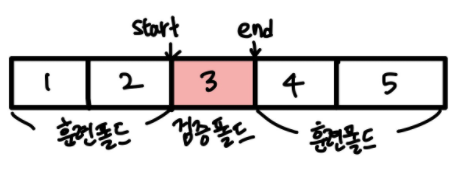

이 코드에서 특히 신경써서 볼 부분은 '훈련 데이터의 표준화 전처리를 폴드를 나눈 후에 수행한다는 점'임.<br>
만약 폴드를 나누기 전에 전체 훈련 데이터를 전처리한다면 검증 폴드의 정보를 누설하게 되는 셈임.<br>
반복문을 진행하며 10개의 검증 폴드로 측정한 성능 점수는 validation_scores 리스트에 저장됨.<br>
성능 점수들의 평균을 내기 위해 np.mean() 함수를 사용함.<br>

k-폴드 교차 검증의 구현이 어렵지는 않지만 보통은 사이킷런에 준비되어 있는 함수를 사용하는 것이 편리함.<br>

이번에는 사이킷런을 이용해 교차 검증을 구현해봄.

<h3>5.4.3 사이킷런으로 교차 검증을 진행함.</h3>

사이킷런의 model_selection 모듈에는 교차 검증을 위한 cross_validate() 함수가 있음. <br>
우리가 만든 SingleLayer 클래스와 cross_validate() 함수를 같이 사용하려면 SinglerLayer 클래스에 몇 가지 기능을 추가해야 함.<br>
(그러나, cross_validate() 함수를 사용하기 위해 여러 기능을 구현하는 것은 공부 목적에 맞지 않으므로 모든 내용을 구현하진 않음)<br>

1. cross_validate() 함수로 교차 검증 점수 계산하기

cross_validate() 함수를 사용하는 방법은 이 함수의 매개변수 값으로 교차 검증을 하고 싶은 모델의 객체와 훈련 데이터, 타깃 데이터를 전달하고 cv 매개변수에 교차 검증을 수행할 폴드 수를 지정하면 됨.<br>
앞에서 만들었던 SGDClassifier 모델과 동일한 매개변수를 사용하여 모델 객체를 만들고 교차 검증을 수행해 봄.

In [40]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))

0.850096618357488


교차 검증의 평균 점수는 약 85%로 낮은 편임.<br>
낮은 이유는 표준화 전처리를 수행하지 않았기 때문임.

<h3>5.4.4 전처리 단계를 포함해 교차 검증을 수행함.</h3>

훈련 세트를 표준화 전처리하기 전에 생각해 볼 것이 있음.<br>
앞에서는 교차 검증을 구현할 때 폴드를 나눈 후에 훈련 폴드의 통계치로 검증 폴드를 전처리 했음.<br>
검증 폴드가 전처리 단계에서 누설되면 안되기 때문임.<br>
만약 훈련 세트 전체를 전처리한 후에 cross_validate() 함수에 매개변수 값으로 전달하면 검증 폴드가 표준화 전처리 단계에서 누설됨.<br>
따라서 새로운 방법을 찾아야 함.

<li>[Pipeline 클래스를 사용해 교차 검증 수행하기]</li>

사이킷런은 검증 폴드가 전처리 단계에서 누설되지 않도록 전처리 단계와 모델 클래스를 하나로 연결해주는 Pipeline 클래스를 제공함.<br>
실제로 Pipeline 클래스와 SGDClassifier 클래스는 어떻게 작동하는가?<br>
먼저 표준화 전처리 단계와 SGDClassifier 클래스 객체를 Pipeline 클래스로 감싸 cross_validate() 함수에 전달함.<br>
그러면 cross_validate() 함수는 훈련 세트를 훈련 폴드와 검증 폴드로 나누기만 하고 전처리 단계와 SGDClassifier 클래스 객체의 호출은 Pipeline 클래스 객체에서 이루어짐.<br>
이렇게 하면 검증 폴드가 전처리 단계에서 누설되지 않게 됨.<br>

물론 Pipeline 클래스 객체를 직접 만들 수도 있음.<br>
하지만 사이킷런은 Pipeline 클래스 객체를 만들어주는 헬퍼 함수를 제공함.<br>
make_pipeline() 함수에 전처리 단계와 모델 객체를 전달하면 파이프라인 객체를 만들 수 있음.<br>
사이킷런에서 표준화 전처리를 수행하는 클래스는 preprocessing 모듈 밑의 StandardScaler 클래스임.<br>
StandardScaler 클래스의 객체와 앞에서 만든 SGDClassifier 클래스의 객체(sgd)를 make_pipeline() 함수에 전달하여 파이프라인 객체를 만듦.<br>
그런 다음 다시 교차 검증 점수를 출력해 봄.

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


평균 검증 점수가 높아짐.<br>
표준화 전처리 단계가 훈련 폴드와 검증 폴드에 올바르게 적용됨.<br>
추가로 cross_validate() 함수에 return_train_score 매개변수를 True로 설정하면 훈련 폴드의 점수도 얻을 수 있음.

In [42]:
print(np.mean(scores['train_score']))

0.9875478561631581
